In [7]:
import numpy as np
import os
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
import h5py
import modisco

In [8]:
def get_basename(path):
    out = os.path.basename(os.path.splitext(path)[0])
    return out

def find_invalid_shapes(array_list, expected_shape):
    invalid_indices = []
    
    for idx, array in enumerate(array_list):
        if array.shape != expected_shape:
            invalid_indices.append(idx)
    
    return invalid_indices

## rewrite to adjust shape of array to (4, len) vs (len, 4) from gkmexplain paper

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((4, len(sequence)), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=0)
    return to_return

def normalize_scores(impscores, hyp_impscores, onehot_data):
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # multiple different bases at a position could produce a similar score,
  # the specific identity of each individual base is less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery. Using normalized importance scores derived by taking
  # the elementwise product of the normalized hypothetical scores and
  # the one-hot encoding also seems to reduce noise.
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
      imp_score_each_pos = np.sum(impscores[i],axis=-1)
      imp_score_sign_each_pos = np.sign(imp_score_each_pos)
      hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                   *imp_score_sign_each_pos[:,None] > 0)
      hyp_scores_same_sign_imp_scores_sum = np.sum(
          hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
      ##!!! with repeats, some impscore = 0 after ohe element-wise multiplication
      ## --> solution: add pseudo count before calculate norm ratio
      hyp_scores_same_sign_imp_scores_sum[hyp_scores_same_sign_imp_scores_sum == 0] = 1e-10
      
      norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
      norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
      normed_hyp_impscores.append(norm_hyp)
      normed_impscores.append(norm_hyp*onehot_data[i])
  return normed_impscores, normed_hyp_impscores

def get_MoLite_inputs(score_file, fasta_file, out=None, out_npz=True):
    ##some lines from score files have issues, remove those
    idx_to_delete= [i for i,x in enumerate(open(score_file)) if len(x.rstrip().split("\t")) < 3]
    # read in seq
    seq=[x.rstrip() 
         for i,x in enumerate(open(fasta_file)) if i%2==1]
    # one-hot encode seq
    ohe=[np.array(one_hot_encode_along_channel_axis(x)) 
                for x in seq if ('N' not in x)] # shape (4,len(seq))
    # remove seq without score from ohe
    ohe = [ohe[i] for i in range(len(ohe)) if i not in idx_to_delete]
    
    ## parse calculated attribute score from lsgkm model and transpose to match array shape
    hypscore=[w[0].T for w in zip([
    np.array( [[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(score_file) if len(x.rstrip().split("\t")) >= 3],seq) if 'N' not in w[1]]
    
    # some scores are of the wrong shape, i.e. not all 500bp were scored, remove from seq & score
    score_idx_rm = find_invalid_shapes(hypscore, (4,500))
    
    ohe = [ohe[i] for i in range(len(ohe)) if i not in score_idx_rm]
    hypscore = [hypscore[i] for i in range(len(hypscore)) if i not in score_idx_rm]
    
    # compute importance score
    impscore=[x * y for x,y in zip(hypscore, ohe)]
    # sanity check
    assert (np.max([np.max(np.abs(z*y - x))for x,y,z in zip(impscore,ohe,hypscore)]))==0
    norm_impscore, norm_hypscore = normalize_scores(impscore, hypscore, ohe)
    #save as npz 
    if (out_npz):
        filename = get_basename(fasta_file)
        np.savez_compressed(os.path.join(out, filename + str('_hypscore')), arr_0=norm_hypscore)
        np.savez_compressed(os.path.join(out, filename + str('_seq')), arr_0=ohe)
    else:
        return norm_impscore, norm_hypscore

In [9]:
def find_matching_index(string_list, target_string):
    for index, string in enumerate(string_list):
        if string == target_string:
            return index
    return -1  # Return -1 if the target string is not found in the list

def viz_weights(array,fname,
                 figsize=(20,3),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.savefig(fname, dpi=300, transparent = True)
    plt.show()

def viz_weightsX(array,
                 figsize=(20,3),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    #plt.savefig(fname, dpi=300, transparent = True)
    plt.show()

## Viz scores for LacZ enhancers

In [3]:
score_lacz = '../data/svm/scores/lacZ_enhancer.hypscore.txt'
seq_lacz = "../_data/lsgkmexplain/_fasta/lacZ_enhancer_seq.fa"

norm_iscore, normed_hypscore = get_MoLite_inputs(score_file = score_lacz, fasta_file=seq_lacz, out_npz=False)

In [5]:
enh_names = [x.rstrip() for (i,x) in enumerate(open(seq_lacz)) if i%2!=1]

enh_names

['>mGata4_Blk1_Icp_peak_11170',
 '>gGata4_Blk1_ICp_peak_31601',
 '>mTbx20_midTAD_ICp_peak_56045',
 '>gTbx20_midTAD_ICp_peak_18886',
 '>mPakap_ICp_peak_38365',
 '>gPakap_ICp_peak_47139',
 '>gNkx2-5_Bnip_IC+_11170',
 '>mNkx2-5_Bnip_IC+_23909',
 '>mHand2_DCp_peak_53425',
 '>gHand2_DCp_peak_34215',
 '>mTbx20_DCp_peak_56041',
 '>gTbx20_DCp_peak_18889']

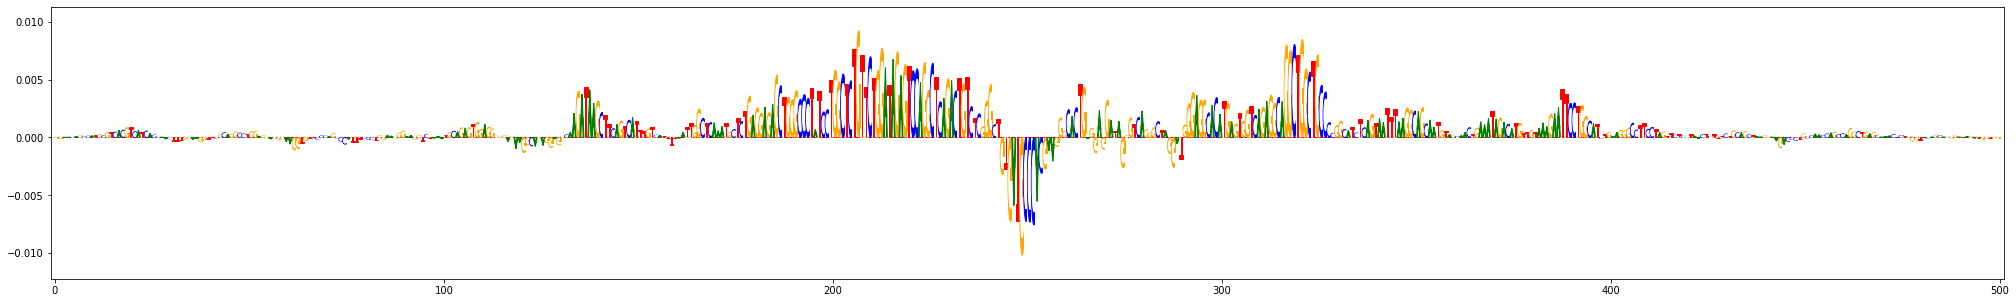

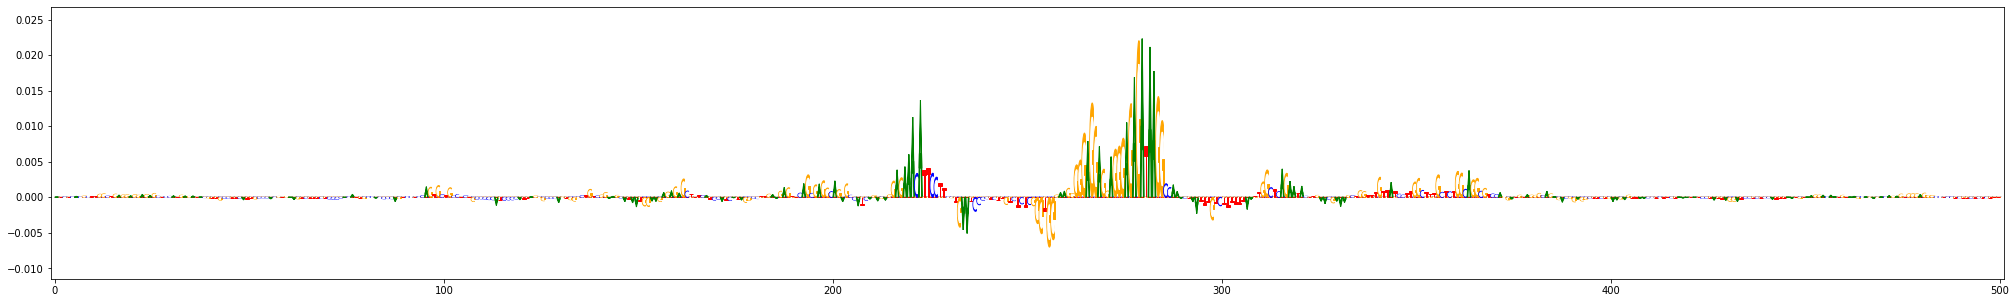

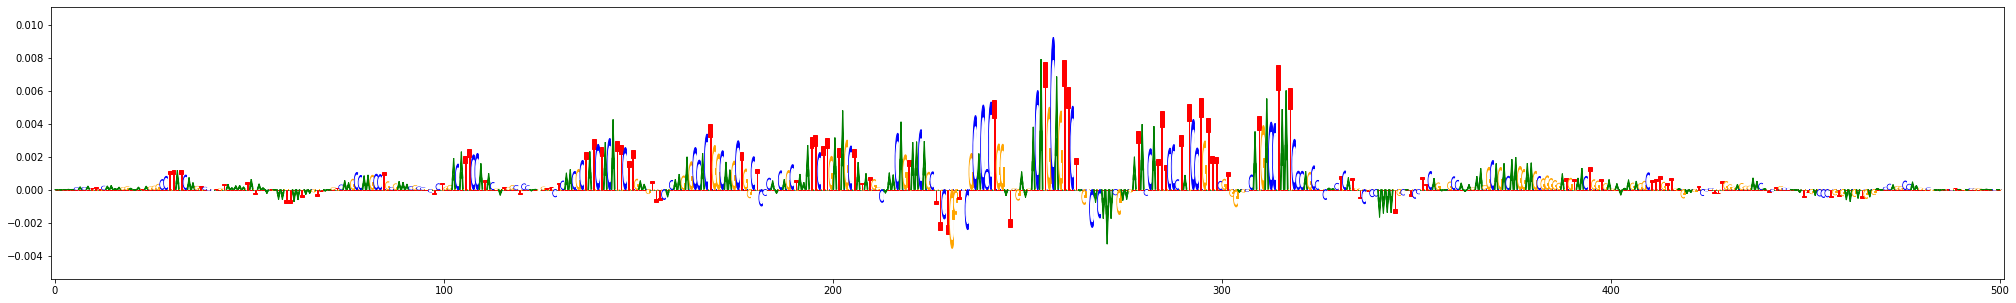

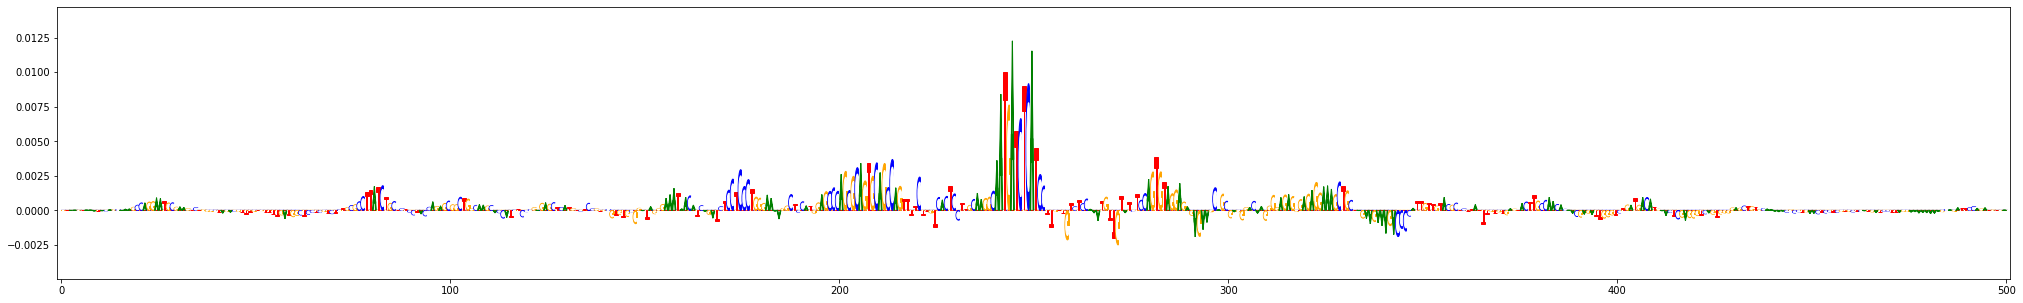

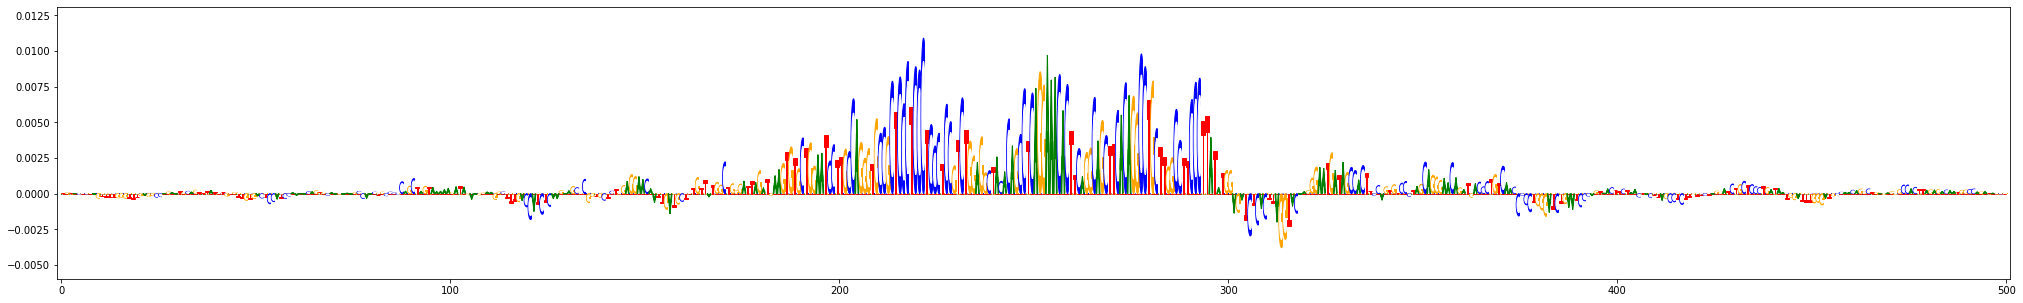

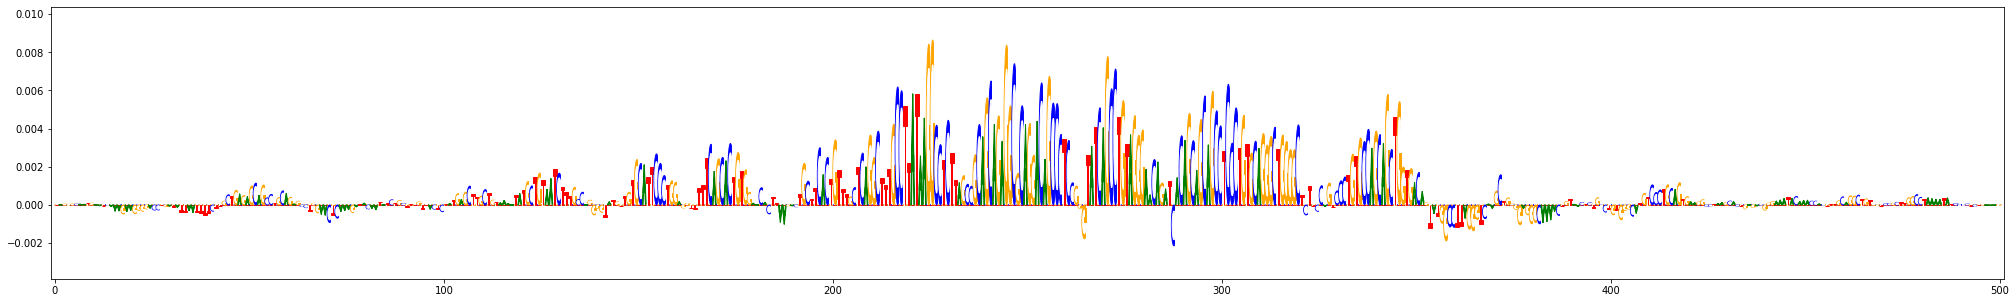

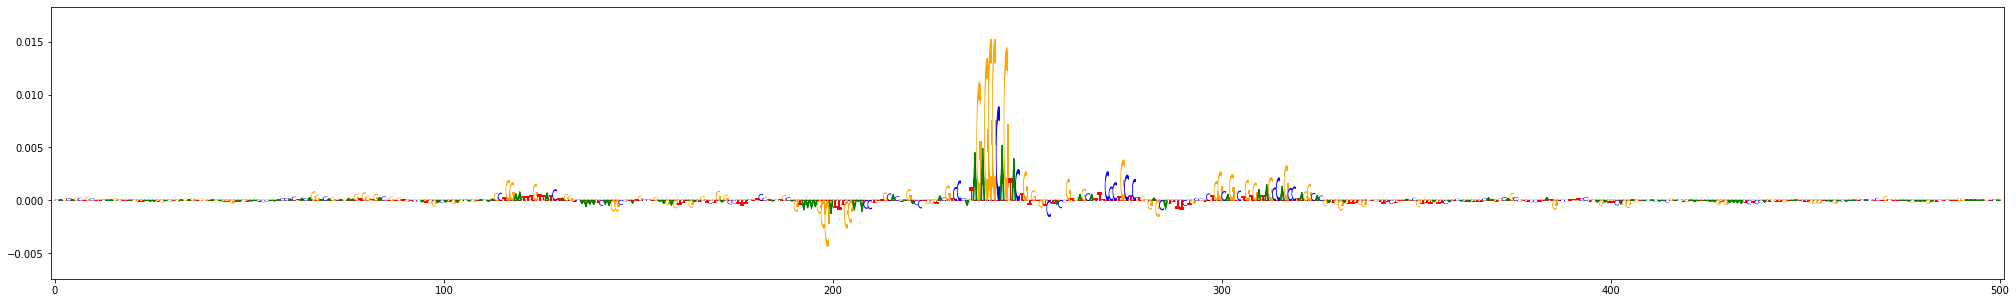

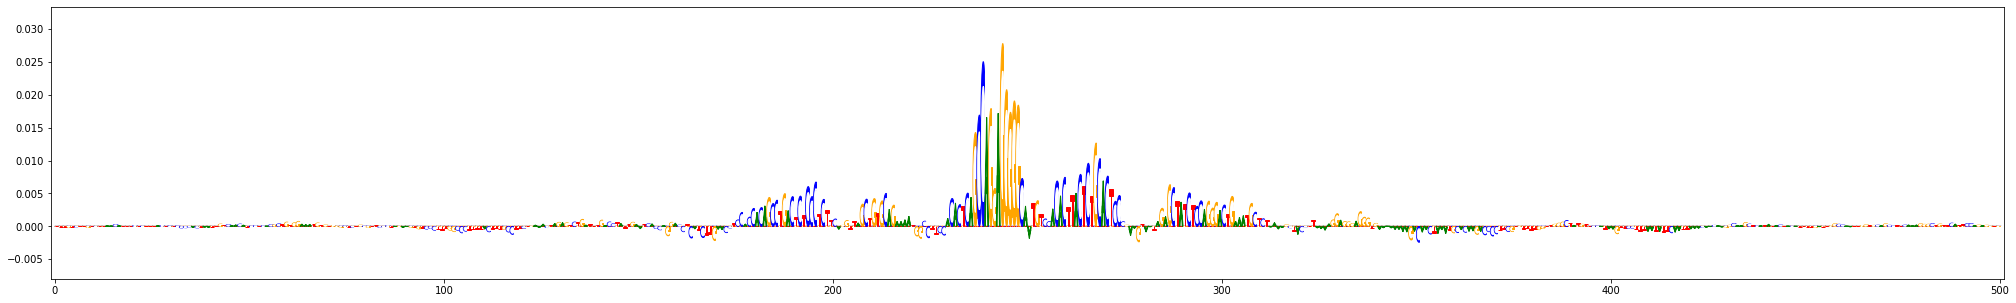

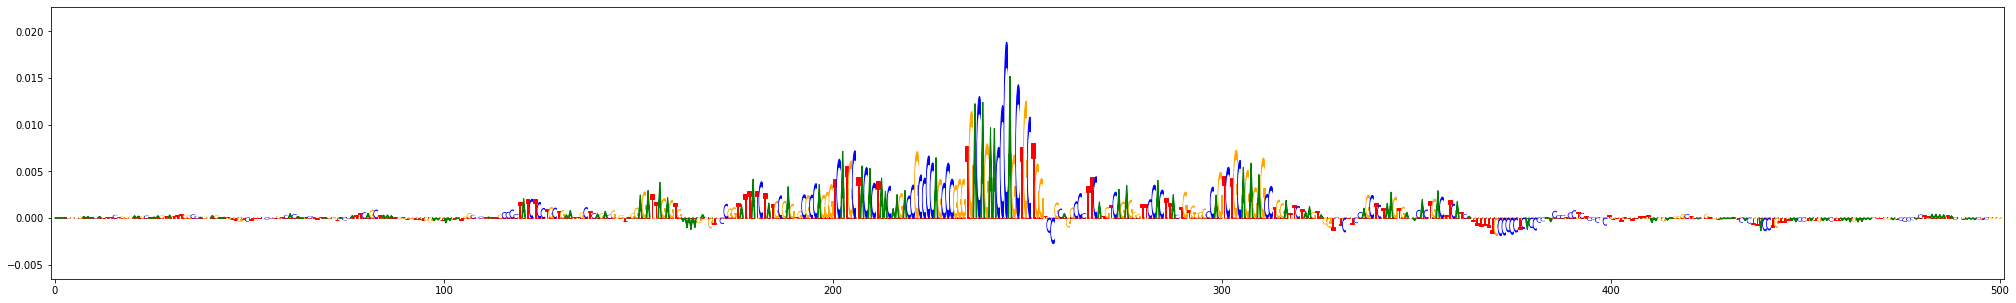

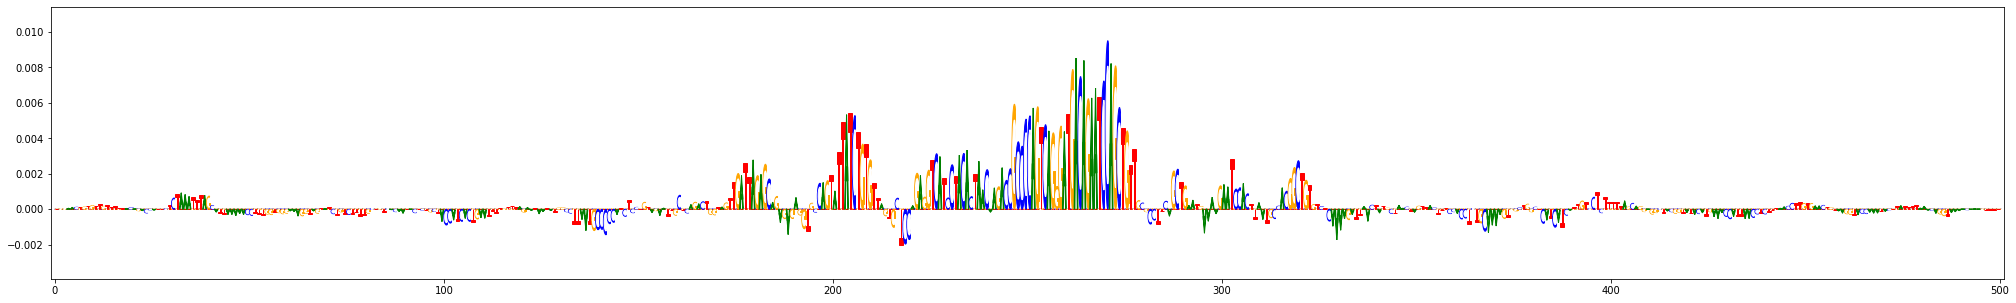

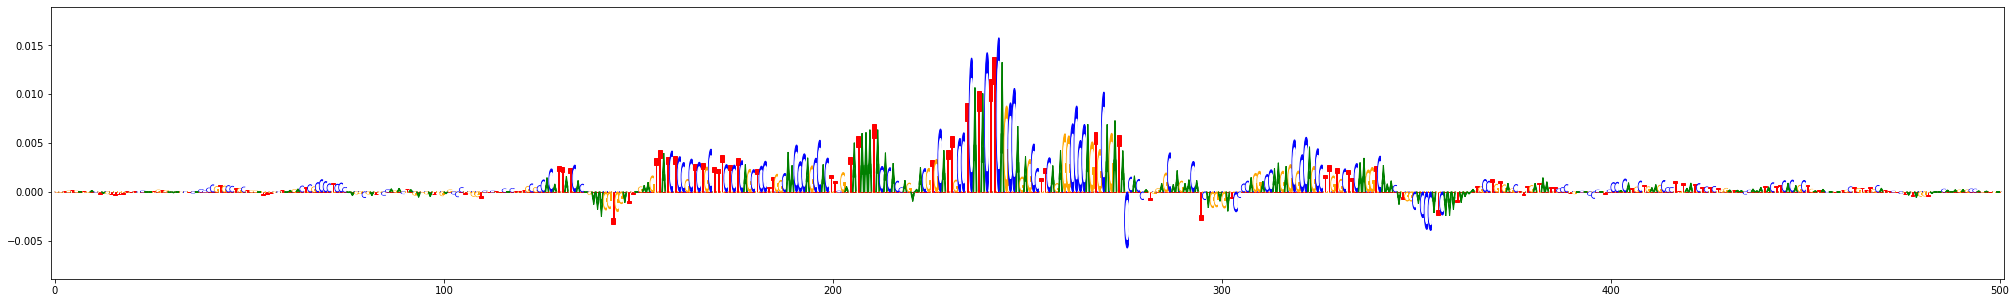

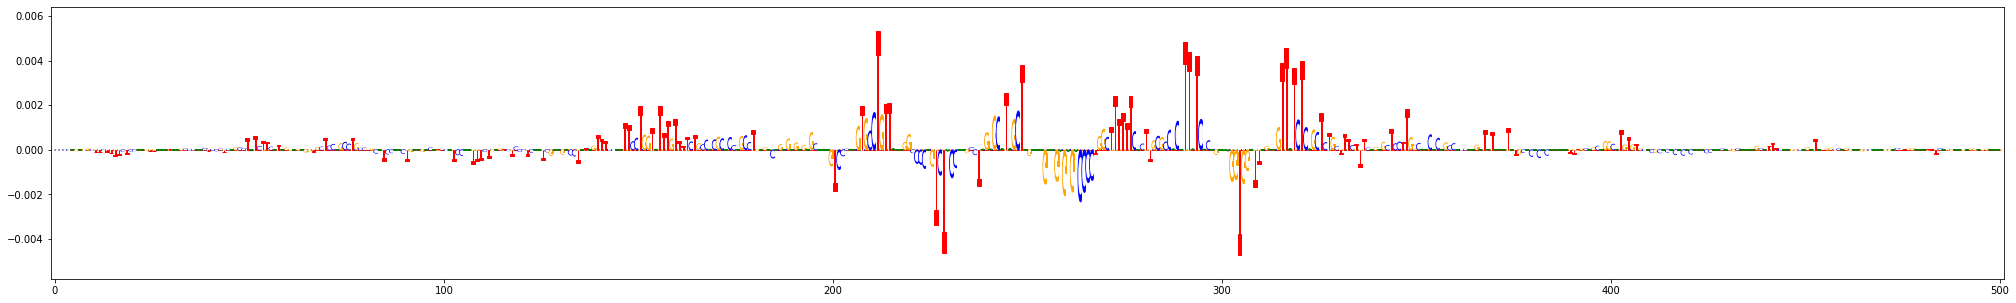

In [10]:
for (i, seq) in enumerate(norm_iscore):
    viz_weights(seq, 
                fname='../figures/' + enh_names[i]+ '_attr_scores_500bp_wrbfgkm.png', 
                figsize=(35,5), 
                subticks_frequency=100)